# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('/datasets/insurance.csv')

In [4]:
print(data.shape)
data.head(10)

(5000, 5)


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
data['Возраст'] = data['Возраст'].astype(int)
data['Зарплата'] = data['Зарплата'].astype(int)

In [7]:
data.duplicated().sum()

153

В данных мы имеем достаточно мало признаков, поэтому можно предполагать, что некоторые данные могут совпадать, поэтому лучше будет оставить дубли без удаления

Теперь посмотрим на распределения по каждому признаку, для этого построим гистограммы

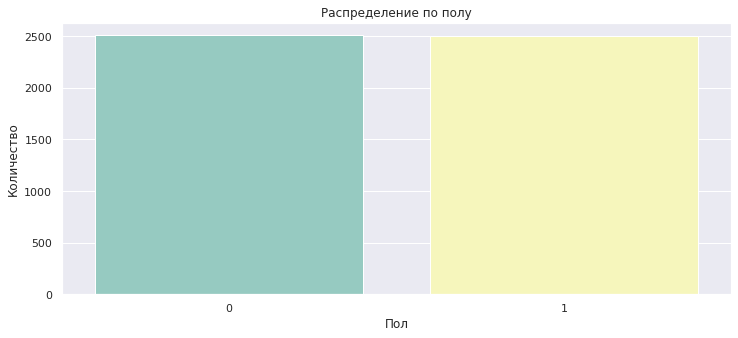

In [8]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x='Пол', data=data, palette="Set3")
ax.set_title('Распределение по полу')
plt.ylabel('Количество');

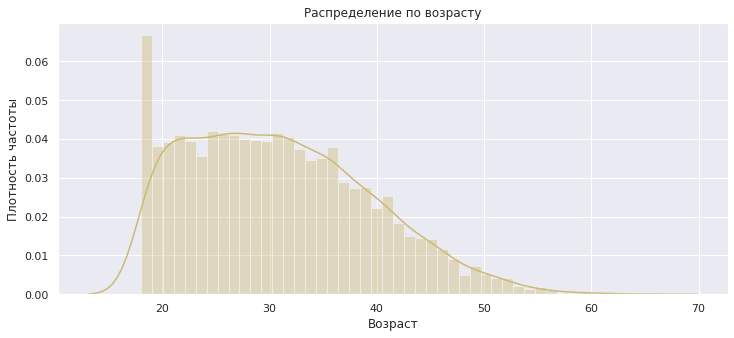

In [9]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(data['Возраст'], bins=len(data['Возраст'].unique()), color="y")
ax.set_title('Распределение по возрасту')
plt.ylabel('Плотность частоты');

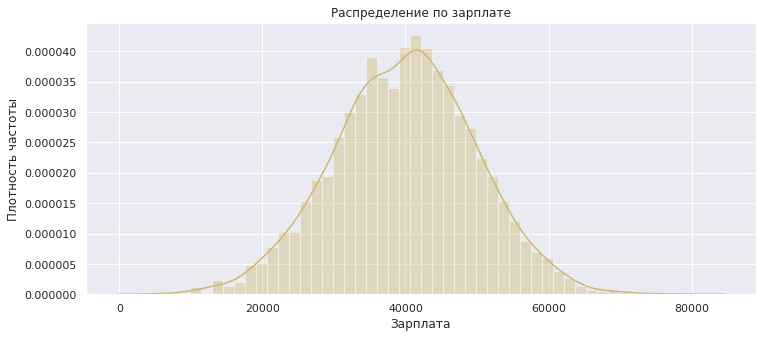

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(data['Зарплата'], color="y")
ax.set_title('Распределение по зарплате')
plt.ylabel('Плотность частоты');

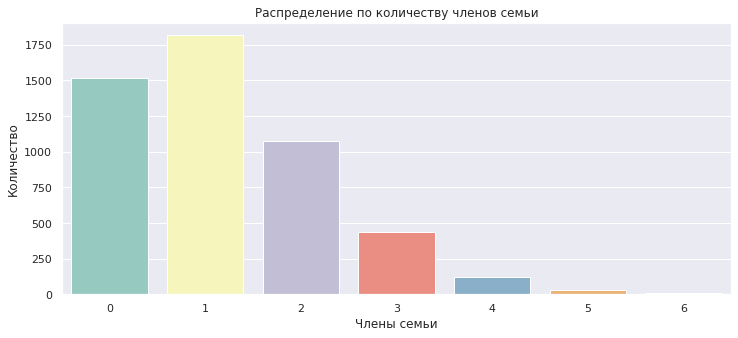

In [11]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x='Члены семьи', data=data, palette="Set3")
ax.set_title('Распределение по количеству членов семьи')
plt.ylabel('Количество');

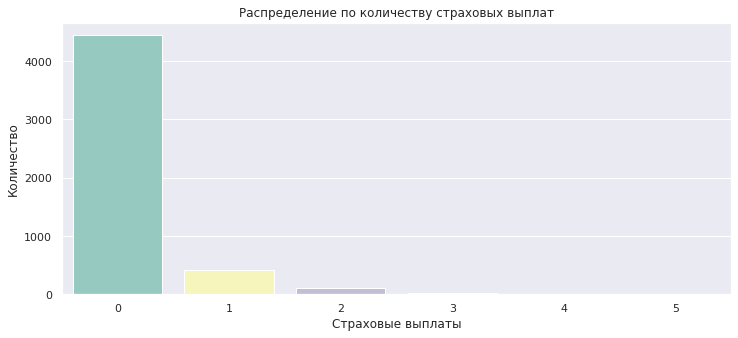

In [12]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x='Страховые выплаты', data=data, palette="Set3")
ax.set_title('Распределение по количеству страховых выплат')
plt.ylabel('Количество');

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Разделим данные на признаки и целевой признак: features и target

In [13]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

Создадим класс LinReg и напишем 2 метода fit и predict.
Первый находит веса w, второй делает предсказания:

In [14]:
class LinReg:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv((X.T @ X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        print(w)
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

Создадим модель, обучим ее и найдем предсказания на обучающей выборке. Также расчитаем значение метрики R2:

In [15]:
model = LinReg()
model.fit(features, target)
predictions = model.predict(features)
r2_score(target, predictions)

[-9.38235447e-01  7.92580563e-03  3.57083050e-02 -1.70081903e-07
 -1.35676627e-02]


0.42494550308169177

Создадим случайную квадратную матрицу, размером по количеству столбцов features

In [16]:
random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
random_matrix

array([[ 0.47951231, -0.38665215, -1.48906052, -0.33057348],
       [ 0.21147788, -1.01793304, -0.42088604, -0.5360131 ],
       [ 0.35740077,  1.60431652,  0.21559846,  0.15300354],
       [ 0.29047457,  0.47934317,  0.22814433, -0.47411612]])

Проверим на обратимость, вызвав np.linalg.inv()

In [17]:
np.linalg.inv(random_matrix)

array([[-1.7742567 ,  6.42593592,  4.97128429, -4.4234723 ],
       [ 0.65063539, -1.96712617, -0.90926825,  1.4768562 ],
       [-1.18950387,  1.94032186,  1.23316405, -0.96630555],
       [-1.00160564,  2.88181698,  2.71983898, -3.79114381]])

Теперь получим единичную матрицу. Для этого перемножим исходную на обратную матрицы

In [18]:
random_matrix @ np.linalg.inv(random_matrix)

array([[ 1.00000000e+00, -1.21795406e-16, -2.49125272e-16,
         8.57409545e-18],
       [ 2.97903144e-19,  1.00000000e+00, -8.97478312e-19,
        -2.65606077e-16],
       [-1.50569891e-16,  3.82224984e-16,  1.00000000e+00,
         2.03691684e-16],
       [-1.56870014e-16, -8.42556773e-17, -8.61662085e-17,
         1.00000000e+00]])

Умножим признаки на обратимую матрицу random_matrix

In [19]:
matrix_features = features.dot(random_matrix)
matrix_features.head()

,0,1,2,3
0,17736.518585,79532.456856,10675.166159,7566.194297
1,13591.247573,60917.682205,8173.608703,5789.003755
2,7511.548949,33661.126874,4515.361875,3197.529935
3,14908.633936,66879.581000,8982.073284,6368.043060
4,9334.560891,41843.772409,5613.845824,3978.053422


Обучим модель на новых признаках, найдем предсказания, и проверим изменится ли качество линейной регрессии

In [20]:
model = LinReg()
model.fit(matrix_features, target)
predictions = model.predict(matrix_features)
r2_score(target, predictions)

[-0.93823515  0.27541383 -0.08512383  0.07296881  0.14640394]


0.42494550308122203

#### Как связаны параметры линейной регрессии в исходной задаче и в преобразованной?

Есть формула для предсказаний:

$$
a = Xw
$$

Т.к. новая матрица признаков получается умножением исходной $Х$ на рандомную $М$, то формула применит вид:

$$
a = X М w
$$
Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$
Тогда перепишем формулу нахождения весов $w1$:

$$
w1 = ((XM)^T XM)^{-1} (XM)^T y
$$
Раскроем скобки:$$
w1 = ((M^T X^T XM)^{-1}M^T X^T y
$$

$(M^T)^{-1} M^T$ это единичная матрица $E$, матрица умножаясь на единичную равна себе, поэтому сократим запись:

$$
w1 =  M^{-1}(X^T X)^{-1} X^T y
$$
То есть новые веса $w1$ выражаются через исходные $w$ следующим образом:$$
w1 =  M^{-1} w
$$

 умножив признаки на обратимую матрицу, качество линейной регрессии не меняется.

## Алгоритм преобразования

Напишем алгоритм, закодировав исходную матрицу:

In [21]:
def encode(features):
    random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
    features_encode = features.dot(random_matrix)
    return features_encode

In [22]:
encode(features)

,0,1,2,3
0,6906.636668,571.589789,-104010.805448,-48371.179040
1,5293.806753,460.807243,-79681.919189,-37060.234920
2,2927.361716,260.512760,-44034.046433,-20481.032575
3,5800.802111,457.999954,-87447.191453,-40664.071345
4,3637.098030,311.585394,-54730.256261,-25454.830588
...,...,...,...,...
4995,4967.940574,408.216991,-74862.394624,-34814.964189
4996,7293.782152,588.026681,-109884.288330,-51098.913705
4997,4715.751309,376.995165,-71089.361163,-33058.503238
4998,4548.149704,368.627515,-68572.291649,-31890.421505


Для расшифровки данных напишем алгоритм (функцию дешифрования), принимающий на вход зашифрованную матрицу features_encode и возвращающая исходную features:

In [23]:
def decode(features_encode):
    features_decode = round(abs(features_encode.dot(np.linalg.inv(random_matrix))))
    for i in features_decode.iloc[:, [0, 3]]:
        features_decode[i] = features_decode[i].astype(int)
    features_decode.columns = features.columns
    return features_decode

In [24]:
features_encode = features.dot(random_matrix)

In [25]:
decode(features_encode)

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


Сравним с features:

In [26]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


#### Почему качество линейной регрессии не поменяется? 

Предсказания высчитываются по формуле:

$$
a = Xw
$$
Т.к. новая матрица признаков получается умножением исходной $Х$ на рандомную $М$, то формула применит вид:

$$
a1 = X М w1
$$
Подставив вычисленное значение весов $w1 =  M^{-1} w$ получаем:

$$
a1 = X М  M^{-1} w
$$
$М M^{-1}$ это еденичная матрица $E$, т.е. можно сократить:

$$
a1 = X w = a
$$
Предсказания по исходной и преобразованной матрицам равны.

## Проверка алгоритма

Проверим, что качество линейной регрессии из sklearn не отличается до и после преобразования. Примените метрику R2.

Создадим модель sklearn_model и обучим на 2 обучающих матрицах - featuresи и features_encode

In [30]:
sklearn_model = LinearRegression().fit(features, target)
pred = sklearn_model.predict(features)
print('R2:',r2_score(target, pred))
print('MSE:',mean_squared_error(target, pred))

R2: 0.42494550308169177
MSE: 0.12334688937098945


In [31]:
sklearn_model.fit(features_encode, target)
pred = sklearn_model.predict(features_encode)
print('R2:',r2_score(target, pred))
print('MSE:',mean_squared_error(target, pred))

R2: 0.42494550308169965
MSE: 0.12334688937098777


Качество линейной регрессии из sklearn до и после преобразования не отличается

## Вывод:

- Познакомились с данными. Изменили тип данных столбцов "Зарплата" и "Возвраст" на целочисленный и посмотрели на распредление признаков - признаки распределены без аномалий
- Определили, что умножив признаки на обратимую матрицу, качество линейной регрессии не меняется. Это обусловленно тем, что новые веса  𝑤1  выражаются через исходные  𝑤  следующим образом:
$$ 𝑤1=𝑀−1𝑤 $$
- Предложили алгоритм преобразования данных для решения задачи, лгоритм позволяет дешифровать данные. Качество линейной регрессии не поменяется.
- Данный вид исходных данных становиться очень сложно восстановить без кода программы, так как в алгоритме реализована случайность, которая при запуске делает зашифрованные данные каждый раз новыми
- Реализованный алгоритм полностью удовлетворяет поставленной задаче Защиты персональных данных клиентов страховой компании